In [1]:
import torch
import pickle
import os,sys
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../../")

from human_aware_rl.rllib.rllib import reset_dummy_policy, gen_trainer_from_params
from human_aware_rl.rllib.utils import get_base_ae
from human_aware_rl.dummy.rl_agent import *
from overcooked_ai_py.agents.agent import AgentPair

In [2]:
def load_checkpoint(file_path):
    assert os.path.isfile(file_path)
    with open(file_path, 'rb') as file:
        checkpoint = pickle.load(file)
    return checkpoint


def run_rl_training(params):
    # Retrieve the tune.Trainable object that is used for the experiment
    trainer = gen_trainer_from_params(params)
    # Object to store training results in
    result = {}

    # Training loop
    for i in range(params['num_training_iters']):
        result = trainer.train()

        msg = result['episode_reward_mean']
        msg2 = result['episode_reward_max']
        msg3 = result['episode_reward_min']
        if i % 10 == 0:
            print(f'{i}: ep rew mean={msg}, max={msg2}, min={msg3}')
        trainer.workers.foreach_worker(lambda ev: reset_dummy_policy(ev.get_policy('dummy')))
    
    return result

def getVisitation(states, joint_action, env):
    target_player_idx = 0
    num_game = len(states)
    freq = {}
    for game, actions in zip(states,joint_action):
        for s,a in zip(game,actions):
            reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
            reward_features = tuple(reward_features)
            if reward_features not in freq:
                freq[reward_features] = 0
            freq[reward_features] += 1
    
    for state in freq:
        freq[state] /= num_game
    return freq

def getExpertStateFeatures(train_config, left_agent, right_agent):
    mdp_params = train_config["environment_params"]["mdp_params"]
    env_params = train_config["environment_params"]["env_params"]
    ae = get_base_ae(mdp_params, env_params)
    env = ae.env


    agent_pair = AgentPair(left_agent, right_agent)
    results = env.get_rollouts(agent_pair=agent_pair, num_games=1, display=False)
    states = results['ep_states']
    actions = results['ep_actions']

    act = []
    for idx in actions[0]:
        act.append([Action.ACTION_TO_INDEX[idx[0]], Action.ACTION_TO_INDEX[idx[1]]])
    actions = act
    states = states[0]

    target_player_idx = 0
    features = []    
    for s,a in zip(states,actions):
        reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
        features.append(reward_features)
    return features

def getAgentVisitation(train_config, env): #get the feature expectations of a new policy using RL agent
    '''
    Trains an RL agent with the current reward function. 
    Then rolls out one trial of the trained agent and calculate the feature expectation of the RL agent.
    - train_config: the configuration taken by the rllib trainer
    
    Returns the feature expectation.
    '''
    # train and get rollouts
    try:
        results = run_rl_training(train_config)
        states = results['evaluation']['states']
        actions = results['evaluation']['actions']
        scores = results['evaluation']['sparse_reward']
        actions = _convertAction2Index(actions)
        state_visit = getVisitation(states, actions, env)
        return state_visit
    except Exception as e:
        print('ERROR: could not get Agent Visitation. --> ' + str(e))

def min_max_scale(a, b=None):
    # apply min-max scaling, range becomes [0,1]
    if b is None:
        mini = torch.min(a)
        maxi = torch.max(a)
        a = (a - mini) / (maxi - mini)
        return a
    else:
        mini = min(torch.min(a), torch.min(b))
        maxi = max(torch.max(a), torch.max(b))
        a = (a - mini) / (maxi - mini)
        b = (b - mini) / (maxi - mini)
        return a,b

In [3]:
coop_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T3_latino/epoch=20.checkpoint"

print(f'loading model checkpoint from {coop_ckpt}...')
coop_ckpt = load_checkpoint(coop_ckpt)

print(f'retrieving reward model and optimizer...')
coop_reward_model = coop_ckpt["reward_model"]

print(f'loading configurations...')
coop_config = coop_ckpt['config']

print(f'getting expert trajectory and state visitation...')
coop_state_visit = coop_ckpt['expert_svf']
print(f'complete')

loading model checkpoint from /home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T3_latino/epoch=20.checkpoint...
retrieving reward model and optimizer...
loading configurations...
getting expert trajectory and state visitation...
complete


In [4]:
noncoop_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T3_white/epoch=30.checkpoint"

print(f'loading model checkpoint from {noncoop_ckpt}...')
noncoop_ckpt = load_checkpoint(noncoop_ckpt)

print(f'retrieving reward model and optimizer...')
noncoop_reward_model = noncoop_ckpt["reward_model"]

print(f'loading configurations...')
noncoop_config = noncoop_ckpt['config']

print(f'getting expert trajectory and state visitation...')
noncoop_state_visit = noncoop_ckpt['expert_svf']
print(f'complete')

loading model checkpoint from /home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T3_white/epoch=30.checkpoint...
retrieving reward model and optimizer...
loading configurations...
getting expert trajectory and state visitation...
complete


In [5]:
COOP_BOT_SVF = getExpertStateFeatures(coop_config, MAICooperativeAgent(), MAIDummyRightCoopAgent())
NONCOOP_BOT_SVF = getExpertStateFeatures(noncoop_config, MAINonCoopAgent(), MAIDummyRightCoopAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 8.00; : 100%|██████████| 1/1 [00:00<00:00, 121.90it/s]


Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 8.00; : 100%|██████████| 1/1 [00:00<00:00, 216.10it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


In [6]:
LEN_BOT_COOP_TRAJ = len(COOP_BOT_SVF) # states are distinct in pre-programmed bots
LEN_BOT_NONCOOP_TRAJ = len(NONCOOP_BOT_SVF) # states are distinct in pre-programmed bots
LEN_HUMAN_COOP_TRAJ = 6.9489
LEN_HUMAN_NONCOOP_TRAJ = 13.5395
def get_stats(reward_model, states):
    lst = []
    hidden = None
    for state in states:
        reward = reward_model.get_rewards(state)
        
        # reward, hidden = reward_model.get_rewards(state, hidden)
        lst.append(reward[0].item())
    lst = torch.tensor(lst)
    return lst

coop_cp = get_stats(coop_reward_model, COOP_BOT_SVF)[:5]
coop_np = get_stats(coop_reward_model, NONCOOP_BOT_SVF)
noncoop_cp = get_stats(noncoop_reward_model, COOP_BOT_SVF)[:5]
noncoop_np = get_stats(noncoop_reward_model, NONCOOP_BOT_SVF)

print(f'coop agent coop behavior: {min_max_scale(coop_cp,coop_np)[0]}')
print(f'coop agent noncoop behavior: {min_max_scale(coop_cp, coop_np)[1]}')
print(f'noncoop agent coop behavior: {min_max_scale(noncoop_cp, noncoop_np)[0]}')
print(f'noncoop agent noncoop behavior: {min_max_scale(noncoop_cp, noncoop_np)[1]}')


coop agent coop behavior: tensor([0.0000, 0.2302, 0.2302, 0.1149, 0.2504])
coop agent noncoop behavior: tensor([0.0000, 0.2302, 0.2302, 0.2754, 0.3405, 0.0089, 0.2114, 1.0000])
noncoop agent coop behavior: tensor([0.0000, 0.1636, 0.1636, 0.0616, 0.1535])
noncoop agent noncoop behavior: tensor([0.0000, 0.1636, 0.1636, 0.1866, 0.2290, 0.0645, 0.2050, 1.0000])


In [7]:
def min_max_scale_with_avg(a, b):
    # apply min-max scaling, range becomes [0,1]
    mini = min(torch.min(a), torch.min(b))
    maxi = max(torch.max(a), torch.max(b))
    a = torch.sum((a - mini) / (maxi - mini)) / len(a)
    b = torch.sum((b - mini) / (maxi - mini)) / len(b)
    return a,b

# scaled average reward per step
avg_coop_cp, avg_coop_np = min_max_scale_with_avg(coop_cp, coop_np)
avg_noncoop_cp, avg_noncoop_np = min_max_scale_with_avg(noncoop_cp, noncoop_np)

print(f'For a reward function derived from cooperative human expert:')
print(f'\tfor cooperative behavior: average reward per step={avg_coop_cp / avg_coop_cp}')
print(f'\tfor non-cooperative behavior: reward per step={avg_coop_np / avg_coop_cp}')

print(f'For a reward function derived from non-cooperative human expert:')
print(f'\tfor cooperative behavior: reward per step={avg_noncoop_cp / avg_noncoop_cp}')
print(f'\tfor non-cooperative behavior: reward per step={avg_noncoop_np / avg_noncoop_cp}')


For a reward function derived from cooperative human expert:
	for cooperative behavior: average reward per step=1.0
	for non-cooperative behavior: reward per step=1.7383418083190918
For a reward function derived from non-cooperative human expert:
	for cooperative behavior: reward per step=1.0
	for non-cooperative behavior: reward per step=2.319033622741699


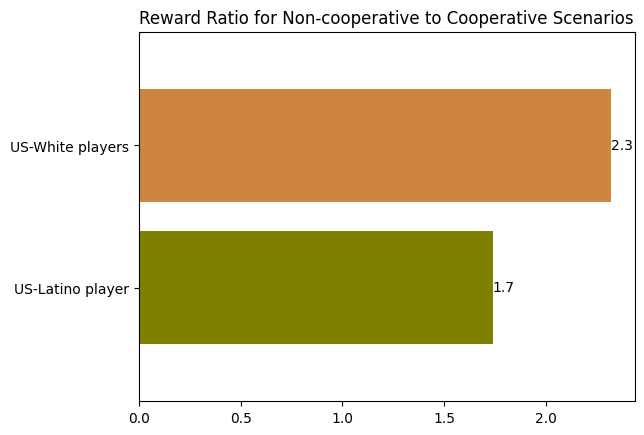

In [8]:
width = 0.4
ratio = [avg_coop_np / avg_coop_cp, avg_noncoop_np / avg_noncoop_cp]
ind = 0.5 * np.arange(2)
label = ['US-Latino player', 'US-White players']

fig, ax = plt.subplots()
bar = ax.barh(ind + 0.5*width, ratio, width, color=['olive', 'peru'])

ratio = ["{:.1f}".format(round(r.item(), 2)) for r in ratio]
plt.bar_label(bar, ratio)

# ax.barh(ind, [coop_noncoop], width, color='olive', label='non-cooperative reward')

ax.set(yticks=ind + 0.5*width, yticklabels=label, ylim=[width - 0.6, 1.1])
ax.set_title('Reward Ratio for Non-cooperative to Cooperative Scenarios')
plt.show()

In [9]:
feat = torch.diag(torch.ones(18))

noncoop_reward_per_feat = noncoop_reward_model.get_rewards(feat).squeeze()
coop_reward_per_feat = coop_reward_model.get_rewards(feat).squeeze()
print(coop_reward_per_feat)
print(noncoop_reward_per_feat)
noncoop_reward_per_feat = min_max_scale(noncoop_reward_per_feat)
coop_reward_per_feat = min_max_scale(coop_reward_per_feat)
print(coop_reward_per_feat)
print(noncoop_reward_per_feat)


tensor([ 0.0706, -0.1480,  0.2816, -0.1146, -0.4199, -0.4814,  0.0173,  0.1633,
        -0.2770, -0.6036, -0.0899, -0.0639,  0.2447,  2.3248, -0.4197,  0.0160,
        -0.3146, -0.1236])
tensor([ 0.2707, -0.3599,  0.3336, -0.1547, -0.2072,  0.3516,  0.6192,  0.7810,
         0.0912, -0.3665,  0.2020,  0.3930,  0.6446,  5.5838,  0.0649,  0.2996,
         0.1982, -0.2182])
tensor([0.2302, 0.1556, 0.3023, 0.1670, 0.0627, 0.0417, 0.2120, 0.2619, 0.1115,
        0.0000, 0.1754, 0.1843, 0.2897, 1.0000, 0.0628, 0.2116, 0.0987, 0.1639])
tensor([0.1071, 0.0011, 0.1177, 0.0356, 0.0268, 0.1207, 0.1657, 0.1929, 0.0769,
        0.0000, 0.0955, 0.1276, 0.1699, 1.0000, 0.0725, 0.1119, 0.0949, 0.0249])


In [10]:
import matplotlib.pyplot as plt

FEATURES_1 = [
    'p0_x', 'p0_y', 'p1_x', 'p1_y', 
    'p0_ori(N)', 'p0_ori(S)', 'p0_ori(E)', 'p0_ori(W)', 
    'p1_ori(N)', 'p1_ori(S)', 'p1_ori(E)', 'p1_ori(W)', 
    'p0_withOnion', 'p1_wOnion', 
    'onion_on_bridge', 
    'onion_in_pot',
    'urgent',
    'sth'
    ]

FEATURES_2 = [
    'p0 onion dx', 'p0 onion dy', 
    'p0 bridge dx', 'p0 bridge dy', 
    'p0 stove dx', 'p0 stove dy', 
    'p0 orientation(N)', 'p0 orientation(S)', 'p0 orientation(E)', 'p0 orientation(W)',  
    'p0 withOnion', 
    'p1 withOnion',
    'onion on bridge',
    'No. of onion in pot',
    'p0 at (4,3) w/ onion',
    'p0 at (4,2) w/ onion',
    'p0 at (4,1) w/ onion',
    'p0 at (3,1) w/ onion',
    ]

FEATURES_3 = [
    'onion_on_bridge', 
    'onion_in_pot'
]

FEATURES = FEATURES_2

In [11]:
import numpy as np 

def plot_bar(rewards1, rewards2, features, title):
    bar_labels_1 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards1]
    bar_labels_2 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards2]
    plt.clf()

    plt.figure() 

    n = len(features)
    r = np.arange(n)
    height = 0.5

    bar_1 = plt.barh(r, rewards1, label="US-Latino player", height=0.4)
    bar_2 = plt.barh(r + height, rewards2, label="US-White player", height=0.4)
    plt.xlim([-0.5, 1.2])
    plt.bar_label(bar_1, bar_labels_1)
    plt.bar_label(bar_2, bar_labels_2)
    plt.yticks(r + height / 2, features)
    plt.legend()
    plt.title(title)
    # plt.plot()
    plt.show
    # plt.savefig('t20_human_reward_comparison.pdf', format='pdf', bbox_inches='tight')

In [12]:

coop_reward_per_feat[0] = -1 * coop_reward_per_feat[0]
coop_reward_per_feat[1] = -1 * coop_reward_per_feat[1]
coop_reward_per_feat[2] = -1 * coop_reward_per_feat[2]
coop_reward_per_feat[3] = -1 * coop_reward_per_feat[3]
noncoop_reward_per_feat[0] = -1 * noncoop_reward_per_feat[0]
noncoop_reward_per_feat[1] = -1 * noncoop_reward_per_feat[1]
noncoop_reward_per_feat[2] = -1 * noncoop_reward_per_feat[2]
noncoop_reward_per_feat[3] = -1 * noncoop_reward_per_feat[3]

<Figure size 640x480 with 0 Axes>

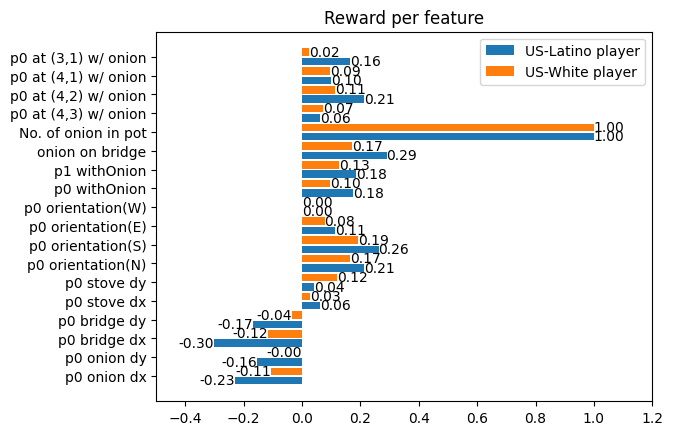

In [13]:
plot_bar(coop_reward_per_feat, noncoop_reward_per_feat, FEATURES, "Reward per feature")

<Figure size 640x480 with 0 Axes>

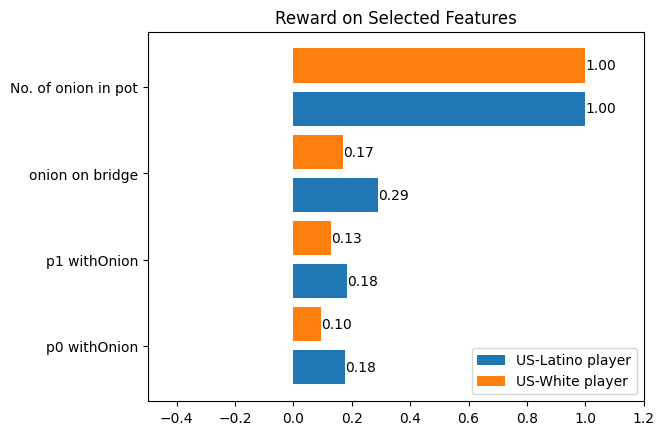

In [14]:
selected_feat_idx = [10, 11, 12, 13]
feature_label = [FEATURES[i] for i in selected_feat_idx]
latino = [coop_reward_per_feat[i] for i in selected_feat_idx]
white = [noncoop_reward_per_feat[i] for i in selected_feat_idx]

plot_bar(latino, white, feature_label, "Reward on Selected Features")

## Get the reward at each position

In [15]:
#    0123456789..
# a: XXXPXXXXPXXX
# b: X    SX 2  X
# c: D XX XX XX S
# d: X   1X     X
# e: XXXXOXX XXDX
# f: XXXXXXX XXXX
# g: XXXXXXX   OX
# h: XXXXXXXXXXXX

ORDER = [
    'xx', 'xx', 'xx', 'xx', 'xx', 'xx',
    'xx', 'b1', 'b2', 'b3', 'b4', 'xx', 
    'xx', 'c1', 'xx', 'xx', 'c4', 'xx', 
    'xx', 'd1', 'd2', 'd3', 'd4', 'xx',
    'xx', 'xx', 'xx', 'xx', 'xx', 'xx',
]

def map_orientation(seq, ni, si, ei, wi):
    mapping = {}
    mapping['N'] = seq[ni] if ni != -1 else None
    mapping['S'] = seq[si] if si != -1 else None
    mapping['E'] = seq[ei] if ei != -1 else None
    mapping['W'] = seq[wi] if wi != -1 else None
    return mapping

def map_seq_to_pos(seq):
    pos = {
        'b1': map_orientation(seq, 11, -1, -1, 27),
        'b2': map_orientation(seq, 13, 14, 12, 26), 
        'b3': map_orientation(seq, 16, 17, 15, 25), 
        'b4': map_orientation(seq, 24, -1, 18, -1),
        'c1': map_orientation(seq, 8, 28, 9, 10), 
        'xx': map_orientation(seq, -1, -1, -1, -1), 
        'c4': map_orientation(seq, 23, 19, 20, 21),
        'd1': map_orientation(seq, -1, 29, -1, 7), 
        'd2': map_orientation(seq, 5, 6, 30, 4), 
        'd3': map_orientation(seq, 2, 3, 31, 1),
        'd4': map_orientation(seq, -1, 22, 32, -1),
    }
    return pos

def get_reward_block(position_map, act):
    block = []
    action = []
    for ord in ORDER:
        val = 0
        values = position_map[ord]
        if act=='all':
            cnt = 0
            for i in ['N', 'S', 'E', 'W']:
                if values[i]:
                    val += values[i].item()
                    cnt += 1
            if cnt:
                val /= cnt
            action.append('O')
        elif act=='best':
            maxi = 0.0
            best_act = 'X'
            for i in ['N', 'S', 'E', 'W']:
                if values[i] and values[i].item() > maxi:
                    maxi = values[i]
                    best_act = i
            val = maxi
            action.append(best_act)
        else:
            if act in values and values[act]:
                val = values[act].item()
                action.append(act)
            else: 
                val = 0.0
                action.append('X')
        block.append(val)

    block = np.array(block)
    block = block.reshape((5, 6))
    action = np.array(action)
    action = action.reshape((5, 6))
    return block, action

def min_max_scale(a):
    # apply min-max scaling, range becomes [0,1]
    mini = torch.min(a)
    maxi = torch.max(a)
    a = (a - mini) / (maxi - mini)
    print(f'max={maxi}, min={mini}')
    return a

In [16]:
horizon = 33
layout_name = "coop_eval_hold_onion"

plt_config = {
   "environment_params": {
        "mdp_params" : {
            "layout_name": layout_name
        },
        "env_params" : {
            "horizon" : horizon
        },
   }
}

eval_states_wo = getExpertStateFeatures(plt_config, MAIEvaluationAgent(), MAIStayAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 33.00; : 100%|██████████| 1/1 [00:00<00:00, 70.43it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


In [17]:
horizon = 33
layout_name = "coop_eval_no_onion"

plt_config = {
   "environment_params": {
        "mdp_params" : {
            "layout_name": layout_name
        },
        "env_params" : {
            "horizon" : horizon
        },
   }
}

eval_states_no = getExpertStateFeatures(plt_config, MAIEvaluationAgent(), MAIStayAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 33.00; : 100%|██████████| 1/1 [00:00<00:00, 82.60it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


In [18]:
coop_eval = torch.concat((get_stats(coop_reward_model, eval_states_wo), get_stats(coop_reward_model, eval_states_no)))
noncoop_eval = torch.concat((get_stats(noncoop_reward_model, eval_states_wo), get_stats(noncoop_reward_model, eval_states_no)))

# scaled average reward per step
avg_coop_rew = min_max_scale(coop_eval)
avg_noncoop_rew = min_max_scale(noncoop_eval)

avg_coop_rew_wo = avg_coop_rew[:33]
avg_coop_rew_no = avg_coop_rew[33:]
avg_noncoop_rew_wo = avg_noncoop_rew[:33]
avg_noncoop_rew_no = avg_noncoop_rew[33:]


max=-2.4384765625, min=-3.3883206844329834
max=-0.6208690404891968, min=-1.4310097694396973


In [19]:
position_map = map_seq_to_pos(avg_coop_rew_wo)
direction = 'all'
block, _ = get_reward_block(position_map, direction)

north_block, _ = get_reward_block(position_map, 'N')
south_block, _ = get_reward_block(position_map, 'S')
east_block, _ = get_reward_block(position_map, 'E')
west_block, _ = get_reward_block(position_map, 'W')


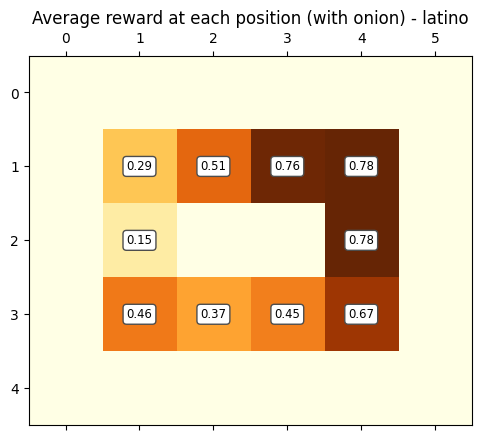

In [20]:
fig, ax = plt.subplots()
ax.matshow(block, cmap='YlOrBr')

for (i, j), z in np.ndenumerate(block):
    if ORDER[i * 6 + j] != 'xx':
        ax.text(j, i, 
                '{:0.2f}'.format(z), 
                ha='center', 
                va='center', 
                size='small',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
                )

ax.set_title(f'Average reward at each position (with onion) - latino')

plt.show()

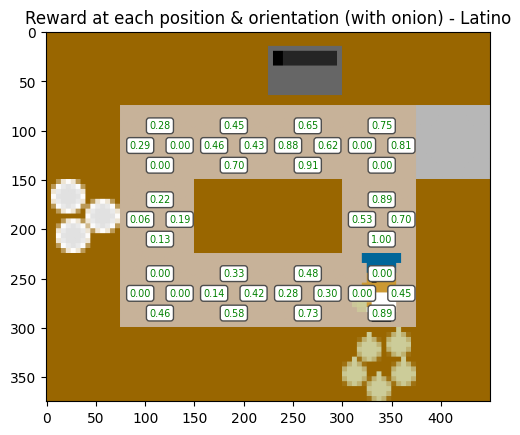

In [21]:
img = plt.imread("/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/start.png")
fig, ax = plt.subplots()

top_y=100
top_x = 0
height = 375
width = 450
ax.imshow(img[top_y:top_y+height, top_x:top_x+width])
# ax.matshow(block, cmap='YlOrBr')



# label the reward value at each position
for (i, j), z in np.ndenumerate(north_block):
    if ORDER[i * 6 + j] != 'xx':
        ax.text(j*75+40, i*75+20, 
                '{:0.2f}'.format(z), 
                ha='center', 
                va='center', 
                size='x-small',
                color='green',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
                )

for (i, j), z in np.ndenumerate(south_block):
    if ORDER[i * 6 + j] != 'xx':
        ax.text(j*75+40, i*75+60, 
                '{:0.2f}'.format(z), 
                ha='center', 
                va='center', 
                size='x-small',
                color='green',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
        )

for (i, j), z in np.ndenumerate(east_block):
    if ORDER[i * 6 + j] != 'xx':
        ax.text(j*75+60, i*75+40, 
                '{:0.2f}'.format(z), 
                ha='center', 
                va='center', 
                size='x-small',
                color='green',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')        
        )

for (i, j), z in np.ndenumerate(west_block):
    if ORDER[i * 6 + j] != 'xx':
        ax.text(j*75+20, i*75+40, 
                '{:0.2f}'.format(z), 
                ha='center', 
                va='center', 
                size='x-small',
                color='green',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
                )

ax.set_title(f'Reward at each position & orientation (with onion) - Latino')

plt.show()

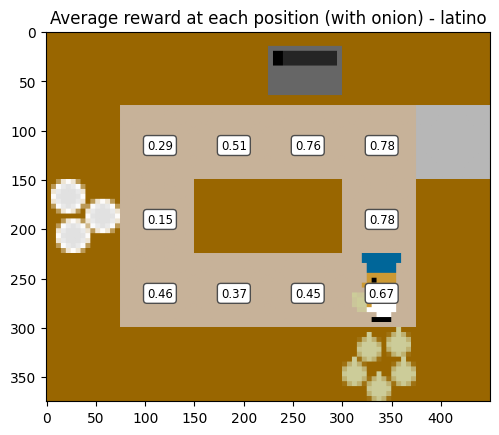

In [22]:
img = plt.imread("/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/start.png")
fig, ax = plt.subplots()

top_y=100
top_x = 0
height = 375
width = 450
ax.imshow(img[top_y:top_y+height, top_x:top_x+width])

# ax.matshow(block, cmap='YlOrBr')

for (i, j), z in np.ndenumerate(block):
    if ORDER[i * 6 + j] != 'xx':
        ax.text(j*75 + 40, i*75 + 40, 
                '{:0.2f}'.format(z), 
                ha='center', 
                va='center', 
                size='small',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
                )

ax.set_title(f'Average reward at each position (with onion) - latino')

plt.show()